## Load Dataset
First I load the dataset from the given link. I would like to know the number of features and observations and the features' names. 

In [25]:
import pandas as pd
df = pd.read_csv(
    "http://www.thetransparencyproject.org/datasets/AnalyticDataset_Gray_LaPlante_PAB_2012.dat",
    delimiter="\\t",
    engine="python",
    na_values=" "
)

print('Number of Observations:',len(df))
print('Here are the features:',df.columns)
print('Here is the number of features',len(df.columns))

Number of Observations: 4132
Here are the features: Index(['UserID', 'RG_case', 'Missing_Daily_Transactions', 'First_Deposit_Date',
       'Registration_date', 'CountryName', 'LanguageName', 'Gender',
       'YearofBirth', 'age_at_registration', 'sum_stakes_fixedodds',
       'sum_bets_fixedodds', 'bettingdays_fixedodds', 'duration_fixedodds',
       'frequency_fixedodds', 'bets_per_day_fixedodds',
       'euros_per_bet_fixedodds', 'net_loss_fixedodds',
       'percent_lost_fixedodds', 'sum_stakes_liveaction',
       'sum_bets_liveaction', 'bettingdays_liveaction', 'duration_liveaction',
       'frequency_liveaction', 'bets_per_day_liveaction',
       'euros_per_bet_liveaction', 'net_loss_liveaction',
       'percent_lost_liveaction', 'sum_stakes_casino', 'sum_bets_casino',
       'bettingdays_casino', 'duration_casino', 'frequency_casino',
       'bets_per_day_casino', 'euros_per_bet_casino', 'net_loss_casino',
       'percent_lost_casino', 'net_loss_fixedodds_nonzero',
       'percen

# Data Types and target 
I want to know the types of features since it is an important step in preprocessing the features. I want to know also how the target/lables values are therefore I print out the RG_case column from the dataframe. 

In [26]:
df_types = df.dtypes
print('Unique types present in the dataframe:',pd.unique(df.dtypes))
Target_clm = 'RG_case'
Id_clm = 'UserID'
unique_labels = df[Target_clm].unique()
print('Unique lables in RG_case column',unique_labels)

Unique types present in the dataframe: [dtype('int64') dtype('O') dtype('float64')]
Unique lables in RG_case column [1 0]


# Class imbalanced or not
To see if I am dealing with an imbalanced dataset, I would like to calculate the percentage of each class with regards to the whole dataset. 

In [27]:
dataset_size = len(df)
for label in unique_labels:
    print(f'The percentage of {label} in the dataset is equal to:',len(df[df[Target_clm]==0])/dataset_size)


The percentage of 1 in the dataset is equal to: 0.5
The percentage of 0 in the dataset is equal to: 0.5


# Columns with constant or near constant values and duplicated columns 
I check for duplicated columns, and columns with constant or near constant values. As these columns do not provide relevant information for our prediction model. In handling near constant columns to make sure I'm not discarding important information, I only remove columns with 99.9% of constant values. 

In [28]:
## Duplicated columns 
feature_df = df.drop(columns=[Target_clm,Id_clm])
duplicated_clms = feature_df.columns[feature_df.T.duplicated()]
print(duplicated_clms)
feature_df.drop(columns=duplicated_clms,inplace=True)


Index([], dtype='object')


In [29]:
## constant columns 
n_unique = feature_df.nunique(dropna=False)
const_clms = n_unique[n_unique<=1].index.tolist()
print('columns with constant values',const_clms)
feature_df.drop(columns=const_clms,inplace = True)

columns with constant values []


In [30]:
## Near constant columns
near_constant_clms = []

for clm in feature_df.columns:
    value_counts = feature_df[clm].value_counts(dropna=False, normalize=True)
    if value_counts.iloc[0] >= 0.999:## this is the threshold which near constant columns are defined
        near_constant_clms.append(clm)

feature_df = feature_df.drop(columns=near_constant_clms)
print('Here are the near constant columns:',near_constant_clms)
print(f"Removed {len(near_constant_clms)} near-constant features")


Here are the near constant columns: []
Removed 0 near-constant features


# Detect Negative Values Where Impossible
I want to detect and remove obviously broken or useless features. If a feature is conceptually non-negative and contains a small number of negative values, I assume upstream data issues and remove the feature rather than silently fixing it. for this purpose I focus on features with numeric values. 

In [31]:
# positive columns with spars negative values
numeric_clms = feature_df.select_dtypes(include=["int64", "float64"]).columns

negative_issue_clms = []

for clm in numeric_clms:
    if (feature_df[clm] < 0).sum() > 0:# If there exists negative values
        if (feature_df[clm] >= 0).mean() > 0.95: #If 95% of the valuse of the column are positive
            negative_issue_clms.append(clm)

print("Columns with suspicious negative values:", negative_issue_clms)
feature_df.drop(columns=negative_issue_clms,inplace=True)

Columns with suspicious negative values: []


# Detect Extremely Large Outliers
I want to detect and remove features with extremly large outliers. 

In [32]:
outlier_clms = []

for clm in numeric_clms:
    series = feature_df[clm].dropna()
    if series.empty:
        continue
    
    q99 = series.quantile(0.99)
    max_val = series.max()

    
    if (q99!=0) & (max_val > 100 * q99): # Extremely conservative: max is 100x larger than 99th percentile
        outlier_clms.append(clm)

print("Columns with extreme outliers:", outlier_clms)
feature_df = feature_df.drop(columns=outlier_clms)


Columns with extreme outliers: []


# Columns with Missing values 
I want to find the columns with missing values and also see the distribution of missing values amongs different columns. I drop columns with more than 25% missing values because heavy missingness often indicates low reliability or inconsistent collection. More advanced imputation can be explored later. 

([], [])

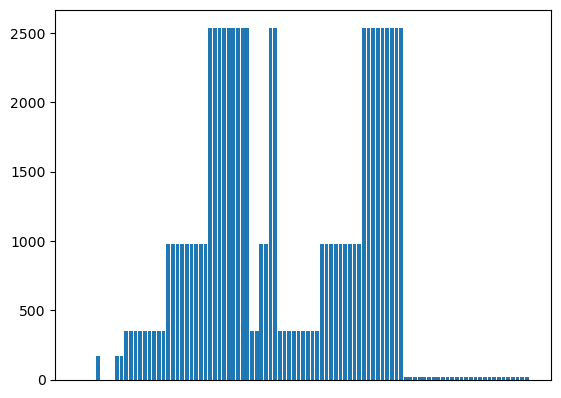

In [33]:
import matplotlib.pyplot as plt
missing_val = df.isna().sum()
plt.bar(df.columns, missing_val)
plt.xticks([])

In [34]:
print('The number of total features:',len(feature_df.columns))
for clm in feature_df.columns:
    if feature_df[clm].isna().mean()>0.25:
        feature_df.drop(clm,axis=1,inplace=True)

print('After droping features wih more that 1000 missing values more than 25% of observations', len(feature_df.columns))

The number of total features: 95
After droping features wih more that 1000 missing values more than 25% of observations 75


# Imputation 
First we do train and test split to avoid data leakage before imputation. For imputation I devide data into two existing categories based of data type.I separate columns by data type because missing values have different meanings depending on the feature. 
- Numerical features: I use median to fill the missing values in numerical features, this is due to robustness of median value again outliers.
- Categorical features: I use the constant value of Missing for categorical features. 

In [40]:
# checking int64 missing values to see if missing might mean 0 or ...
int_clms = feature_df.select_dtypes(include=['int64']).columns
print('columns with integer values:',int_clms)
print(feature_df[int_clms].isna().sum())

columns with integer values: Index(['Missing_Daily_Transactions'], dtype='object')
Missing_Daily_Transactions    0
dtype: int64


In [41]:
from sklearn.model_selection import train_test_split

lable = df[Target_clm]

x_train,x_test,y_train,y_test = train_test_split(
    feature_df,lable,test_size= 0.2,stratify=lable,random_state=42)

In [42]:
numerical_features = x_train.select_dtypes(include=['int64','float64']).columns
categorical_features = x_train.select_dtypes(include=['object','category']).columns 


In [10]:
# Numerical imputation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])


In [11]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


In [12]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# Full Model pipeline 
I now focus on the full model pipeline where is starts by preprocessing and then a simple explainanle model.

In [13]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced",
        max_iter=1500,
        random_state=42
    ))
])

model.fit(x_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.83      0.80       414
           1       0.82      0.76      0.79       413

    accuracy                           0.80       827
   macro avg       0.80      0.80      0.80       827
weighted avg       0.80      0.80      0.80       827



In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=50,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(x_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [16]:
y_pred = rf_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       414
           1       0.81      0.74      0.77       413

    accuracy                           0.78       827
   macro avg       0.78      0.78      0.78       827
weighted avg       0.78      0.78      0.78       827

